In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
import os
from sklearn.preprocessing import LabelEncoder,StandardScaler, OneHotEncoder
from scipy.sparse import csr_matrix, hstack
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import StratifiedKFold
from sklearn.metrics import log_loss
from sklearn.feature_extraction.text import TfidfTransformer,TfidfVectorizer,CountVectorizer
from sklearn.cluster import KMeans
from xgboost import XGBClassifier
from sklearn.calibration import CalibratedClassifierCV
import warnings
warnings.filterwarnings("ignore")

S:\ana\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation,BatchNormalization
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
from keras.optimizers import SGD,Adagrad
from keras.layers.advanced_activations import PReLU
from sklearn.cross_validation import train_test_split
from keras.callbacks import EarlyStopping,TensorBoard
from statistics import mean

Using TensorFlow backend.


In [3]:
gatrain = pd.read_csv("data/gender_age_train.csv",index_col='device_id')
gatest = pd.read_csv("data/gender_age_test.csv",index_col='device_id')
phone=pd.read_csv("data/phone_brand_device_model.csv")
app_label=pd.read_csv('data/app_labels.csv')
label_cat=pd.read_csv("data/label_categories.csv")
app_events=pd.read_csv("data/app_events.csv", dtype={'is_active':bool})
events = pd.read_csv('data/events.csv',  parse_dates=['timestamp'],index_col='event_id')

In [4]:
phone = phone.drop_duplicates('device_id',keep='first').set_index('device_id') #removing duplicate device id's

## Section 5:Data Engineering 

Data is cleaned and prepared so that releveant features can be extracted whiloe modelling. Some of the code snippets were referred from this [kaggle starter kernel](https://www.kaggle.com/dvasyukova/a-linear-model-on-apps-and-labels)

### 5.1: Splitting data based on missing values

Training data and test data are divided into 2 groups:
    1. Data which contains events information
    2. Data which does not contain events information

In [5]:
#https://docs.scipy.org/doc/numpy/reference/generated/numpy.in1d.html
mask=np.in1d(gatrain.index,events["device_id"].values)
gatrain_events= gatrain[mask]

mask=np.in1d(gatest.index,events["device_id"].values)
gatest_events= gatest[mask]

In [6]:
#https://docs.scipy.org/doc/numpy/reference/generated/numpy.in1d.html
mask=np.in1d(gatrain.index,events["device_id"].values,invert=True)
gatrain_noevents= gatrain[mask]

mask=np.in1d(gatest.index,events["device_id"].values,invert=True)
gatest_noevents= gatest[mask]

In [7]:
#Each row of is given by a unique integer as an identifier

gatrain['trainrow'] = np.arange(gatrain.shape[0])
gatest['testrow'] = np.arange(gatest.shape[0])

gatrain_events['trainrow']=np.arange(gatrain_events.shape[0])
gatest_events['testrow']=np.arange(gatest_events.shape[0])

gatrain_noevents['trainrow']=np.arange(gatrain_noevents.shape[0])
gatest_noevents['testrow']=np.arange(gatest_noevents.shape[0])

In [8]:
print("train data with events information:",gatrain_events.shape)
print("train data without events information:",gatrain_noevents.shape)
print("test data with events information:",gatest_events.shape)
print("test data without events information:",gatest_noevents.shape)

train data with events information: (23309, 4)
train data without events information: (51336, 4)
test data with events information: (35194, 1)
test data without events information: (76877, 1)


### 5.2: Vectorising phone brand

In [9]:
brandencoder = LabelEncoder().fit(phone.phone_brand)
phone['brand'] = brandencoder.transform(phone['phone_brand'])
nbrand=len(brandencoder.classes_)

### 5.3: Vectorising  phone model

In [10]:
m = phone.phone_brand.str.cat(phone.device_model)
#m=phone['phone_brand'].str.cat(phone['device_model'])
modelencoder = LabelEncoder().fit(m)
phone['model'] = modelencoder.transform(m)
nmodel=len(modelencoder.classes_)

### 5.4: Feature enginnering app-id's

Number of times each app was used in a particular device-id

In [11]:

appencoder = LabelEncoder().fit(app_events['app_id'])
app_events['app'] = appencoder.transform(app_events['app_id'])


napps = len(appencoder.classes_)

deviceapps = (app_events.merge(events[['device_id']], how='left',left_on='event_id',right_index=True)
                       .groupby(['device_id','app'])['app'].agg(['size'])# grouping by device id and app and finding size of app
                       .merge(gatrain_events[['trainrow']], how='left', left_index=True, right_index=True)#finding trainrow
                       .merge(gatest_events[['testrow']], how='left', left_index=True, right_index=True)#finding testrow
                       .reset_index())
deviceapps.head()

,device_id,app,size,trainrow,testrow
0,-9222956879900151005,548,18,5145.0,NaN
1,-9222956879900151005,1096,18,5145.0,NaN
2,-9222956879900151005,1248,26,5145.0,NaN
3,-9222956879900151005,1545,12,5145.0,NaN
4,-9222956879900151005,1664,18,5145.0,NaN


### 5.5:Feature engineering app label

Simlar to above, we find number of a times an app with an unique category was used by a device id

In [12]:
app_label = app_label.loc[app_label.app_id.isin(app_events.app_id.unique())]
app_label['app'] = appencoder.transform(app_label.app_id)
labelencoder = LabelEncoder().fit(app_label.label_id)
app_label['label'] = labelencoder.transform(app_label.label_id)
nlabels = len(labelencoder.classes_)

In [13]:
devicelabels = (deviceapps[['device_id','app']]
                .merge(app_label[['app','label']])
                .groupby(['device_id','label'])['app'].agg(['size'])
                .merge(gatrain_events[['trainrow']], how='left', left_index=True, right_index=True)
                .merge(gatest_events[['testrow']], how='left', left_index=True, right_index=True)
                .reset_index())
devicelabels.head()

,device_id,label,size,trainrow,testrow
0,-9222956879900151005,117,1,5145.0,NaN
1,-9222956879900151005,120,1,5145.0,NaN
2,-9222956879900151005,126,1,5145.0,NaN
3,-9222956879900151005,138,2,5145.0,NaN
4,-9222956879900151005,147,2,5145.0,NaN


### 5.6: Processing Time 

we are processing timestamp feature to get information such as hour and day in which device was active.
also we are binning the hours into 4 groups which can be used as features

In [14]:
events['hour'] = events['timestamp'].map(lambda x:pd.to_datetime(x).hour)
events['hourbin'] = [1 if ((x>=1)&(x<=6)) else 2 if ((x>=7)&(x<=12)) else 3 if ((x>=13)&(x<=18)) else 4 for x in events['hour']]

In [15]:
events.hour=events.hour.astype(str)
events.hourbin=events.hourbin.astype(str)

we know that a device could have been used multiple times while using variuos apps. Therefore we are trying to concatenate all the times(day,hour,hourbin) in which the device was being used. This will be later to vectorise training and test data to create one-hot/tf-idf features

In [16]:
hourjoin = events.groupby("device_id")["hour"].apply(lambda x: " ".join('0'+str(s) for s in x))

In [17]:
hourbinjoin=events.groupby("device_id")["hourbin"].apply(lambda x: " ".join('0'+str(s) for s in x))

In [18]:
daysjoin=events['timestamp'].dt.day_name()
events['day']=daysjoin.map({'Sunday':0,'Monday':1,'Tuesday':2,'Wednesday':3,'Thursday':4,'Friday':5,'Saturday':6})

In [19]:
daysjoin = events.groupby("device_id")["day"].apply(lambda x: " ".join("0"+str(s) for s in x))

### 5.7: Processing Latitudes and longitudes

similar to above, we are concatenating all the latitudes during which device was being used.The same is done to longitudes.
Upon analysis it was found that certain latitudes and longitudes have values zero(can be considered outliers).
Therefore we are taking the median of latitudes of a device (median prone to outliers) which can be used as features

In [20]:
median_lat = events.groupby("device_id")["latitude"].agg('median')

In [21]:
median_lon=events.groupby("device_id")["longitude"].agg('median')

#### additionally we are clustering median latitudes and median longitudes into 10 clusters 

In [22]:
com=pd.concat([median_lat, median_lon], axis=1)
kmeans = KMeans(n_clusters=10, random_state=0).fit(com)
clustered_geo_features=pd.Series(kmeans.labels_)
clustered_geo_features.index=median_lon.index

### 5.8: Processing App_active feature

A single device id can have more than 1 eventid and a event id  can have more than one app id.So we are grouping is active feature with event id and mapping the event id from app_events to event id in events. Finally for a device id we are concatenating all the active and inactive apps 

In [23]:
apps = app_events.groupby("event_id")["is_active"].apply(lambda x: " ".join(str(s) for s in x))

In [24]:
events["apps_active"] = events.index.map(apps)
active_apps_events = events.groupby("device_id")["apps_active"].apply(lambda x: " ".join(str(s) for s in x if str(s)!='nan'))


# Section 6: Modelling(Approach 1)


In this approach we try to create fetaures for training data as a whole(without splitting data based on misssing values) and model it.

## 6.1: Creating Features

Reference link for using [csr-matrix](https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.sparse.csr_matrix.html)

### 6.1.1: one-hot encoding phone-brand

In [25]:
gatrain['brand'] = phone['brand']
gatest['brand'] = phone['brand']

Xtr_brand = csr_matrix((np.ones(gatrain.shape[0]), 
                       (gatrain.trainrow, gatrain.brand)))
Xte_brand = csr_matrix((np.ones(gatest.shape[0]), 
                       (gatest.testrow, gatest.brand)))

### 6.1.2: one-hot encoding phone-model

In [26]:
gatrain['model'] = phone['model']
gatest['model'] = phone['model']

Xtr_model = csr_matrix((np.ones(gatrain.shape[0]), 
                       (gatrain.trainrow, gatrain.model)))
Xte_model = csr_matrix((np.ones(gatest.shape[0]), 
                       (gatest.testrow, gatest.model)))

### 6.1.3: one-hot encode device apps 

In [23]:
d = deviceapps.dropna(subset=['trainrow'])
Xtr_app = csr_matrix((np.ones(d.shape[0]), (d.trainrow, d.app)), 
                      shape=(gatrain.shape[0],napps))
d = deviceapps.dropna(subset=['testrow'])
Xte_app = csr_matrix((np.ones(d.shape[0]), (d.testrow, d.app)), 
                      shape=(gatest.shape[0],napps))

### 6.1.4: one-hot encode app category/label 

In [24]:
d = devicelabels.dropna(subset=['trainrow'])
Xtr_label = csr_matrix((np.ones(d.shape[0]), (d.trainrow, d.label)), 
                      shape=(gatrain.shape[0],nlabels))
d = devicelabels.dropna(subset=['testrow'])
Xte_label = csr_matrix((np.ones(d.shape[0]), (d.testrow, d.label)), 
                      shape=(gatest.shape[0],nlabels))

In [25]:
Xtrain = hstack((Xtr_brand, Xtr_model, Xtr_app, Xtr_label), format='csr')
Xtest =  hstack((Xte_brand, Xte_model, Xte_app, Xte_label), format='csr')
print('Train data shape:',Xtrain.shape)
print('Test data shape:',Xtest.shape)

Train data shape: (74645, 21527)
Test data shape: (112071, 21527)


In [26]:
#applying applying label encoding on target variable
targetencoder = LabelEncoder().fit(gatrain.group)
y = targetencoder.transform(gatrain.group)
nclasses = len(targetencoder.classes_)

In [22]:
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import train_test_split

In [28]:
#splitting data into train and validation
xtr, xcv, ytr, ycv = train_test_split(Xtrain, y,stratify=y,test_size=0.15)

## 6.2: Model

### 6.2.1:Logistic regression

In [29]:
#using logistic regression and fitting caliberation model on top of it to get probability scores
alpha = [0.001,0.01,0.02,0.1,1,10]


for i in alpha:
    clf = LogisticRegression(C=i, class_weight='balanced', multi_class='multinomial',solver='lbfgs')
    clf.fit(xtr, ytr)
    #Using Model Calibration
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(xtr, ytr)
    predict_y = sig_clf.predict_proba(xcv)
    print('For values of C = ', i, "The log loss is:",log_loss(ycv, predict_y))



For values of C =  0.001 The log loss is: 2.41107405432861
For values of C =  0.01 The log loss is: 2.409967633564006
For values of C =  0.02 The log loss is: 2.412348775785886
For values of C =  0.1 The log loss is: 2.418234892824304
For values of C =  1 The log loss is: 2.42249858642622
For values of C =  10 The log loss is: 2.4235729131699397


#### C=0.01 gives the best results

In [30]:
clf = LogisticRegression(C=0.01, class_weight='balanced', multi_class='multinomial', solver='lbfgs')
clf.fit(xtr, ytr)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(xcv, ycv)

predict_y = sig_clf.predict_proba(xtr)
loss=log_loss(ytr, predict_y)
print("The train log loss for best C is:",loss)
predict_y = sig_clf.predict_proba(xcv)
loss=log_loss(ycv, predict_y)
print("The validation log loss for best C is:",loss)

The train log loss for best C is: 2.41697627331442
The validation log loss for best C is: 2.3379110492346884


### 6.2.2: Neural network

In [39]:
from keras.callbacks import EarlyStopping,TensorBoard
early_stop=EarlyStopping(monitor='val_loss',patience=5,restore_best_weights=True)

Model architecture referred from this [kaggle discuission forum](https://www.kaggle.com/c/talkingdata-mobile-user-demographics/discussion/23424)

In [40]:
model = Sequential()
model.add(Dense(150, input_dim=xtr.shape[1], init='normal'))
model.add(PReLU())
model.add(Dropout(0.4))
model.add(Dense(50, input_dim=xtr.shape[1], init='normal'))
model.add(PReLU())
model.add(Dropout(0.2))
model.add(Dense(12, init='normal', activation='softmax'))
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

S:\ana\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(150, input_dim=21527, kernel_initializer="normal")`
  
S:\ana\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(50, input_dim=21527, kernel_initializer="normal")`
  """
S:\ana\lib\site-packages\ipykernel_launcher.py:8: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(12, activation="softmax", kernel_initializer="normal")`
  


In [41]:
fit= model.fit(xtr, ytr,nb_epoch=15,validation_data=(xcv, ycv),callbacks=[early_stop])

S:\ana\lib\site-packages\ipykernel_launcher.py:1: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  """Entry point for launching an IPython kernel.


Train on 63448 samples, validate on 11197 samples
Epoch 1/15
63448/63448 [==============================] - 170s 3ms/step - loss: 2.4177 - acc: 0.1386 - val_loss: 2.3995 - val_acc: 0.1482
Epoch 2/15
63448/63448 [==============================] - 166s 3ms/step - loss: 2.3956 - acc: 0.1493 - val_loss: 2.3970 - val_acc: 0.1542
Epoch 3/15
63448/63448 [==============================] - 169s 3ms/step - loss: 2.3815 - acc: 0.1563 - val_loss: 2.4034 - val_acc: 0.1493
Epoch 4/15
63448/63448 [==============================] - 167s 3ms/step - loss: 2.3591 - acc: 0.1661 - val_loss: 2.4038 - val_acc: 0.1548
Epoch 5/15
63448/63448 [==============================] - 168s 3ms/step - loss: 2.3327 - acc: 0.1755 - val_loss: 2.4164 - val_acc: 0.1564
Epoch 6/15
63448/63448 [==============================] - 167s 3ms/step - loss: 2.3000 - acc: 0.1871 - val_loss: 2.4484 - val_acc: 0.1541
Epoch 7/15
63448/63448 [==============================] - 169s 3ms/step - loss: 2.2653 - acc: 0.2013 - val_loss: 2.4502 - 

#### best validation log loss was 2.3990 at epoch 2 after which model overfits.

In [46]:
pred=model.predict(xcv)
loss=log_loss(ycv,pred)
print("log loss for validation data:",loss)

log loss for validation data: 2.3969534551542635


### 6.2.3: Conslusions from approach 1:

1. The log-loss is reaching about 2.33 for validation data
2. validation log loss for neural network is about 2.39
3. Adding new features  and sticking to this approach might not drastically improve results

# Section 7: Modelling (Approach 2)

Approach reffered from this [kaggle deiscuission forum](https://www.kaggle.com/c/talkingdata-mobile-user-demographics/discussion/23424)

Step 1: Split data into data which contains events and data which does not contain events

Step 2: Apply seperate model on the split data
    1. For devices without events: model using features phone model and phone brand(whole training data) and predict for test data without events
    2. For devices without: model using phone brand , phone ,features from evnts file(time, geographical) using training data which has events information and predict with   test data with events
    
Step 3: concatenate the predictions
               

## 7.1:devices without events

### 7.1.1: Creating features

In [27]:
Xtrain_whole = hstack((Xtr_brand, Xtr_model), format='csr')

targetencoder = LabelEncoder().fit(gatrain.group)
y = targetencoder.transform(gatrain.group)

In [28]:
gatest_noevents['model']=phone['model']
gatest_noevents['brand']=phone['brand']

In [29]:
gatest_noevents_model = csr_matrix((np.ones(gatest_noevents.shape[0]), 
                       (gatest_noevents.testrow, gatest_noevents.model)))

gatest_noevents_brand= csr_matrix((np.ones(gatest_noevents.shape[0]), 
                       (gatest_noevents.testrow, gatest_noevents.brand)))

In [30]:
xtest_noevents=hstack((gatest_noevents_brand, gatest_noevents_model), format='csr')

In [31]:
print("xtrain shape:",Xtrain_whole.shape)
print("ytrain shape:",y.shape)

print("xtest shape:",xtest_noevents.shape)

xtrain shape: (74645, 1798)
ytrain shape: (74645,)
xtest shape: (76877, 1798)


In [32]:
xtr, xcv, ytr, ycv = train_test_split(Xtrain_whole, y,stratify=y,test_size=0.15,random_state=18)

### 7.1.2:Model-1(Logistic regression):

In [32]:
# Train a Logistic regression+Calibration model using text features whicha re on-hot encoded
alpha = [0.001,0.01,0.02,0.1,0.15,1,10]


for i in alpha:
    clf = LogisticRegression(C=i, class_weight='balanced', multi_class='multinomial',solver='lbfgs')
    clf.fit(xtr, ytr)
    #Using Model Calibration
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(xtr, ytr)
    predict_y = sig_clf.predict_proba(xcv)
    print('For values of C = ', i, "The validation log loss is:",log_loss(ycv, predict_y))



For values of C =  0.001 The validation log loss is: 2.4030020103020036
For values of C =  0.01 The validation log loss is: 2.39641152579951
For values of C =  0.02 The validation log loss is: 2.3940695248817785
For values of C =  0.1 The validation log loss is: 2.3896730084069544
For values of C =  0.15 The validation log loss is: 2.3891201368497037
For values of C =  1 The validation log loss is: 2.39105667945638
For values of C =  10 The validation log loss is: 2.398847882073424


#### C=0.15 gives least log loss

In [55]:
clf = LogisticRegression(C=0.15, class_weight='balanced', multi_class='multinomial', solver='lbfgs')
clf.fit(xtr, ytr)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(xtr, ytr)

predict_y = sig_clf.predict_proba(xtr)
loss=log_loss(ytr, predict_y)
print("The train log loss for best C is:",loss)
predict_y = sig_clf.predict_proba(xcv)
loss=log_loss(ycv, predict_y)
print("The validation log loss for best C is:",loss)

The train log loss for best C is: 2.362802878894095
The validation log loss for best C is: 2.3891201368497037


In [56]:
no_events_pred_lr=sig_clf.predict_proba(xtest_noevents)

In [42]:
from sklearn.externals import joblib as jobl
from joblib import dump

In [93]:
np.save('results/lr_noevents',no_events_pred_lr)

### 7.1.3:Neural Network 1

Model architecture from this [kaggle deiscuission forum](https://www.kaggle.com/c/talkingdata-mobile-user-demographics/discussion/23424)

In [33]:
def noevents_nn_model1(input_shape):
    model = Sequential()
    model.add(Dense(256, input_dim=input_shape))
    model.add(PReLU())
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(64))
    model.add(PReLU())
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(12))
    model.add(Activation('softmax'))
    model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
    return model

In [34]:
model_sum=noevents_nn_model1(xtr.shape[1])
model_sum.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 256)               460544    
_________________________________________________________________
p_re_lu_1 (PReLU)            (None, 256)               256       
_________________________________________________________________
batch_normalization_1 (Batch (None, 256)               1024      
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                16448     
_________________________________________________________________
p_re_lu_2 (PReLU)    

In [35]:
early_stop=EarlyStopping(monitor='val_loss',patience=5,restore_best_weights=True)

A neural network ensemble was utilised to get better results. Refer [this](https://machinelearningmastery.com/model-averaging-ensemble-for-deep-learning-neural-networks/) for more information

In [37]:
def noevents_average_nn_1(state):
    """
    Takes a list of Random Seeds, splits the data into Train and CV based on Seed, trains model and takes average of 
    predictions while testing  
    """
    model_list=[]
    loss_list=[]
    avg_cv_loss=0
    for i in range(len(state)):
        xtr, xcv, ytr, ycv = train_test_split(Xtrain_whole, y,stratify=y,test_size=0.15,random_state=state[i])
        ytr=np_utils.to_categorical(ytr)
        ycv=np_utils.to_categorical(ycv)
        model=noevents_nn_model1(xtr.shape[1])
        model.fit(xtr, ytr, batch_size=256, epochs=20, verbose=1, validation_data=(xcv, ycv),callbacks=[early_stop])
        model.save('saved_models/noevents/nn'+str(i+1))
        pred=model.predict_proba(xcv)
        cv_loss=log_loss(ycv, pred)
        print("Validation Log Loss of  Model in Current Run: ",cv_loss)
        model_list.append(model)
        loss_list.append(cv_loss)
    avg_cv_loss=mean(loss_list)
    print("Average CV Loss of "+str(len(state))+" Runs :",avg_cv_loss)
    return(model_list)


In [38]:
random_seeds=[9,18,42,86,103]
model_list_1= noevents_average_nn_1(random_seeds)

Instructions for updating:
Use tf.cast instead.
Train on 63448 samples, validate on 11197 samples
Epoch 1/20
63448/63448 [==============================] - 5s 74us/step - loss: 2.9367 - acc: 0.1069 - val_loss: 2.4152 - val_acc: 0.1473
Epoch 2/20
63448/63448 [==============================] - 4s 56us/step - loss: 2.4932 - acc: 0.1292 - val_loss: 2.3989 - val_acc: 0.1512
Epoch 3/20
63448/63448 [==============================] - 4s 56us/step - loss: 2.4199 - acc: 0.1462 - val_loss: 2.3960 - val_acc: 0.1512
Epoch 4/20
63448/63448 [==============================] - 4s 57us/step - loss: 2.4005 - acc: 0.1530 - val_loss: 2.3941 - val_acc: 0.1535
Epoch 5/20
63448/63448 [==============================] - 4s 56us/step - loss: 2.3921 - acc: 0.1551 - val_loss: 2.3920 - val_acc: 0.1545
Epoch 6/20
63448/63448 [==============================] - 4s 57us/step - loss: 2.3840 - acc: 0.1597 - val_loss: 2.3914 - val_acc: 0.1541
Epoch 7/20
63448/63448 [==============================] - 4s 56us/step - loss: 2

In [39]:
avg_pred=np.zeros((xtr.shape[0],12))
for i in range(len(model_list_1)):
    train_pred=model_list_1[i].predict_proba(xtr)
    avg_pred+=train_pred
avg_pred/=len(model_list_1)
print("Train Average Log-Loss: ",log_loss(ytr, avg_pred))

Train Average Log-Loss:  2.350490308773346


In [40]:
avg_pred=np.zeros((xcv.shape[0],12))
for i in range(len(model_list_1)):
    cv_pred=model_list_1[i].predict_proba(xcv)
    avg_pred+=cv_pred
avg_pred/=len(model_list_1)
print("Validation Average Log-Loss: ",log_loss(ycv, avg_pred))

Validation Average Log-Loss:  2.3547159292952924


In [91]:
avg_pred=np.zeros((xtest_noevents.shape[0],12))
for i in range(len(model_list_1)):
    test_pred=model_list_1[i].predict_proba(xtest_noevents)
    avg_pred+=test_pred
avg_pred/=len(model_list_1)

In [96]:
np.save('results/nn1_noevents',avg_pred)

#### Observations:

1. The train and validation log-loss are 2.351 and 2.354 respectively
2. the validation log-loss is better than the logistic regression model (section 7.1.2)

### 7.1.4: Neural Network 2

Model architecture from this [kaggle deiscuission forum](https://www.kaggle.com/c/talkingdata-mobile-user-demographics/discussion/23424)

In [100]:
def noevents_nn_model2(input_dim,output_dim, learRate=0.0025):
    
    model = Sequential()
    model.add(Dense(500, input_shape=(input_dim,), init='uniform'))
    model.add(PReLU(init='zero'))
    model.add(Dropout(0.82))
    model.add(Dense(output_dim, init='uniform'))
    model.add(Activation('softmax'))
    opt = Adagrad(lr=learRate, epsilon=1e-08)
    model.compile(loss='categorical_crossentropy',
                  optimizer=opt,
                  metrics=['accuracy'])
    return model

In [101]:
model_sum=noevents_nn_model2(xtr.shape[1],12)
model_sum.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_148 (Dense)            (None, 500)               10788500  
_________________________________________________________________
p_re_lu_106 (PReLU)          (None, 500)               500       
_________________________________________________________________
dropout_148 (Dropout)        (None, 500)               0         
_________________________________________________________________
dense_149 (Dense)            (None, 12)                6012      
_________________________________________________________________
activation_22 (Activation)   (None, 12)                0         
Total params: 10,795,012
Trainable params: 10,795,012
Non-trainable params: 0
_________________________________________________________________


In [110]:
early_stop=EarlyStopping(monitor='val_loss',patience=5,restore_best_weights=True)

A neural network ensmeble was utilised to get better results. Refer [this](https://machinelearningmastery.com/model-averaging-ensemble-for-deep-learning-neural-networks/) for more information

In [114]:
def noevents_average_nn_2(state):
    """
    Takes a list of Random Seeds, splits the data into Train and CV based on Seed, trains model and takes average of 
    predictions while testing  
    """
    model_list=[]
    loss_list=[]
    avg_cv_loss=0
    for i in range(len(state)):
        xtr, xcv, ytr, ycv = train_test_split(Xtrain_whole, y,stratify=y,test_size=0.15,random_state=state[i])
        ytr=np_utils.to_categorical(ytr)
        ycv=np_utils.to_categorical(ycv)
        model=noevents_nn_model2(xtr.shape[1],12)
        #logdir = os.path.join("logs","noevents_nn1."+str(i+1))
        #t_callback=TensorBoard(log_dir=logdir)
        model.fit(xtr, ytr, batch_size=256, epochs=30, verbose=1, validation_data=(xcv, ycv),callbacks=[early_stop])
        pred=model.predict_proba(xcv)
        cv_loss=log_loss(ycv, pred)
        print("Validation Log Loss of  Model in Current Run: ",cv_loss)
        model_list.append(model)
        loss_list.append(cv_loss)
    avg_cv_loss=mean(loss_list)
    print("Average CV Loss of "+str(len(state))+" Runs :",avg_cv_loss)
    return(model_list)


In [115]:
random_seeds=[9,18,42,86,103]
model_list_2= noevents_average_nn_2(random_seeds)

S:\ana\lib\site-packages\ipykernel_launcher.py:4: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(500, input_shape=(1798,), kernel_initializer="uniform")`
  after removing the cwd from sys.path.
S:\ana\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Update your `PReLU` call to the Keras 2 API: `PReLU(alpha_initializer="zero")`
  """
S:\ana\lib\site-packages\ipykernel_launcher.py:7: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(12, kernel_initializer="uniform")`
  import sys


Train on 63448 samples, validate on 11197 samples
Epoch 1/30
63448/63448 [==============================] - 6s 88us/step - loss: 2.4321 - acc: 0.1346 - val_loss: 2.4171 - val_acc: 0.1389
Epoch 2/30
63448/63448 [==============================] - 5s 75us/step - loss: 2.4143 - acc: 0.1431 - val_loss: 2.4116 - val_acc: 0.1415
Epoch 3/30
63448/63448 [==============================] - 5s 76us/step - loss: 2.4093 - acc: 0.1446 - val_loss: 2.4083 - val_acc: 0.1444
Epoch 4/30
63448/63448 [==============================] - 5s 76us/step - loss: 2.4059 - acc: 0.1455 - val_loss: 2.4060 - val_acc: 0.1458
Epoch 5/30
63448/63448 [==============================] - 6s 95us/step - loss: 2.4028 - acc: 0.1503 - val_loss: 2.4043 - val_acc: 0.1456
Epoch 6/30
63448/63448 [==============================] - 5s 85us/step - loss: 2.4012 - acc: 0.1488 - val_loss: 2.4031 - val_acc: 0.1475
Epoch 7/30
63448/63448 [==============================] - 5s 79us/step - loss: 2.3981 - acc: 0.1510 - val_loss: 2.4020 - val_acc

S:\ana\lib\site-packages\ipykernel_launcher.py:4: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(500, input_shape=(1798,), kernel_initializer="uniform")`
  after removing the cwd from sys.path.
S:\ana\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Update your `PReLU` call to the Keras 2 API: `PReLU(alpha_initializer="zero")`
  """
S:\ana\lib\site-packages\ipykernel_launcher.py:7: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(12, kernel_initializer="uniform")`
  import sys


Train on 63448 samples, validate on 11197 samples
Epoch 1/30
63448/63448 [==============================] - 6s 90us/step - loss: 2.4333 - acc: 0.1327 - val_loss: 2.4172 - val_acc: 0.1464
Epoch 2/30
63448/63448 [==============================] - 5s 80us/step - loss: 2.4157 - acc: 0.1427 - val_loss: 2.4113 - val_acc: 0.1473A: 1s - loss: 2.4171 - acc: - ETA: 1s - loss: 2.4170 - acc: 0.14 - ETA: 1s - loss: 2.4166 - acc: 0. - ETA: 1s - loss: 2.4163 - a - ETA: 0s - loss: 2.4158 - acc:
Epoch 3/30
63448/63448 [==============================] - 5s 77us/step - loss: 2.4103 - acc: 0.1454 - val_loss: 2.4075 - val_acc: 0.1471: 0s - loss: 2.4112 - acc
Epoch 4/30
63448/63448 [==============================] - 5s 77us/step - loss: 2.4066 - acc: 0.1467 - val_loss: 2.4049 - val_acc: 0.145659 - acc: 0.14 - ETA: 2s - loss: 2.4063 - ac - ETA: 1s
Epoch 5/30
63448/63448 [==============================] - 5s 77us/step - loss: 2.4043 - acc: 0.1472 - val_loss: 2.4029 - val_acc: 0.1464044 - acc: 0 - ETA: 0s - lo

S:\ana\lib\site-packages\ipykernel_launcher.py:4: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(500, input_shape=(1798,), kernel_initializer="uniform")`
  after removing the cwd from sys.path.
S:\ana\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Update your `PReLU` call to the Keras 2 API: `PReLU(alpha_initializer="zero")`
  """
S:\ana\lib\site-packages\ipykernel_launcher.py:7: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(12, kernel_initializer="uniform")`
  import sys


Train on 63448 samples, validate on 11197 samples
Epoch 1/30
63448/63448 [==============================] - 6s 92us/step - loss: 2.4316 - acc: 0.1359 - val_loss: 2.4154 - val_acc: 0.1414
Epoch 2/30
63448/63448 [==============================] - 5s 81us/step - loss: 2.4146 - acc: 0.1430 - val_loss: 2.4094 - val_acc: 0.1421
Epoch 3/30
63448/63448 [==============================] - 5s 76us/step - loss: 2.4095 - acc: 0.1459 - val_loss: 2.4057 - val_acc: 0.1452
Epoch 4/30
63448/63448 [==============================] - 5s 77us/step - loss: 2.4064 - acc: 0.1458 - val_loss: 2.4032 - val_acc: 0.1462
Epoch 5/30
63448/63448 [==============================] - 5s 78us/step - loss: 2.4033 - acc: 0.1482 - val_loss: 2.4011 - val_acc: 0.1464oss: 2.4039 - - ETA: 2s - loss: 2.4047 - - ETA: 1s - lo - ETA: 0s - loss: 2.4039 - a
Epoch 6/30
63448/63448 [==============================] - 5s 77us/step - loss: 2.4011 - acc: 0.1482 - val_loss: 2.3995 - val_acc: 0.1470
Epoch 7/30
63448/63448 [====================

S:\ana\lib\site-packages\ipykernel_launcher.py:4: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(500, input_shape=(1798,), kernel_initializer="uniform")`
  after removing the cwd from sys.path.
S:\ana\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Update your `PReLU` call to the Keras 2 API: `PReLU(alpha_initializer="zero")`
  """
S:\ana\lib\site-packages\ipykernel_launcher.py:7: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(12, kernel_initializer="uniform")`
  import sys


Train on 63448 samples, validate on 11197 samples
Epoch 1/30
63448/63448 [==============================] - 6s 94us/step - loss: 2.4318 - acc: 0.1363 - val_loss: 2.4160 - val_acc: 0.1431
Epoch 2/30
63448/63448 [==============================] - 5s 81us/step - loss: 2.4151 - acc: 0.1439 - val_loss: 2.4100 - val_acc: 0.14382s - loss: 2.4148 - acc: 0.145 - ETA: 2s - loss: 2.4145 - acc: 0.14 - ETA: 2s - loss: 2. - ETA: 1s - loss: 2
Epoch 3/30
63448/63448 [==============================] - 5s 78us/step - loss: 2.4099 - acc: 0.1438 - val_loss: 2.4061 - val_acc: 0.1445
Epoch 4/30
63448/63448 [==============================] - 5s 78us/step - loss: 2.4061 - acc: 0.1478 - val_loss: 2.4035 - val_acc: 0.1471
Epoch 5/30
63448/63448 [==============================] - 5s 78us/step - loss: 2.4033 - acc: 0.1472 - val_loss: 2.4015 - val_acc: 0.1492
Epoch 6/30
63448/63448 [==============================] - 5s 78us/step - loss: 2.4012 - acc: 0.1487 - val_loss: 2.3999 - val_acc: 0.1493ss: 2.4008 -  - ETA: 

S:\ana\lib\site-packages\ipykernel_launcher.py:4: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(500, input_shape=(1798,), kernel_initializer="uniform")`
  after removing the cwd from sys.path.
S:\ana\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Update your `PReLU` call to the Keras 2 API: `PReLU(alpha_initializer="zero")`
  """
S:\ana\lib\site-packages\ipykernel_launcher.py:7: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(12, kernel_initializer="uniform")`
  import sys


Train on 63448 samples, validate on 11197 samples
Epoch 1/30
63448/63448 [==============================] - 6s 94us/step - loss: 2.4321 - acc: 0.1352 - val_loss: 2.4167 - val_acc: 0.1408
Epoch 2/30
63448/63448 [==============================] - 5s 79us/step - loss: 2.4144 - acc: 0.1441 - val_loss: 2.4107 - val_acc: 0.1424
Epoch 3/30
63448/63448 [==============================] - 5s 78us/step - loss: 2.4093 - acc: 0.1462 - val_loss: 2.4072 - val_acc: 0.1424
Epoch 4/30
63448/63448 [==============================] - 5s 77us/step - loss: 2.4058 - acc: 0.1467 - val_loss: 2.4048 - val_acc: 0.1419
Epoch 5/30
63448/63448 [==============================] - 5s 78us/step - loss: 2.4024 - acc: 0.1473 - val_loss: 2.4031 - val_acc: 0.1432
Epoch 6/30
63448/63448 [==============================] - 5s 81us/step - loss: 2.4008 - acc: 0.1482 - val_loss: 2.4017 - val_acc: 0.1433oss: 2.3971 - - ETA: 2s - loss: 2.3975 - ac - E - ETA: 0s - loss: 2.4004 - acc: 0.14 - ETA: 0s - loss: 2.4003 - acc: 0. - ETA: 0s

In [116]:
avg_pred=np.zeros((xtr.shape[0],12))
for i in range(len(model_list_2)):
    train_pred=model_list_2[i].predict_proba(xtr)
    avg_pred+=train_pred
avg_pred/=len(model_list_2)
print("Train Average Log-Loss: ",log_loss(ytr, avg_pred))

Train Average Log-Loss:  2.3773803963269122


In [120]:
avg_pred=np.zeros((xcv.shape[0],12))
for i in range(len(model_list_2)):
    cv_pred=model_list_2[i].predict_proba(xcv)
    avg_pred+=cv_pred
avg_pred/=len(model_list_2)
print("Validation Average Log-Loss: ",log_loss(ycv, avg_pred))

Validation Average Log-Loss:  2.3792368855138477


In [118]:
avg_pred=np.zeros((xtest_noevents.shape[0],12))
for i in range(len(model_list_2)):
    test_pred=model_list_2[i].predict_proba(xtest_noevents)
    avg_pred+=test_pred
avg_pred/=len(model_list_2)

In [119]:
np.save('results/nn2_noevents',avg_pred)

#### Observations:

1. The train and average log loss was 2.373 and 2.379 respectively
2. this model performs better than logistic regression(section 7.1.2) but worse than neural network 1(section 7.1.3)

### 7.1.5: XGboost

Model parameters from this [kaggle deiscuission forum](https://www.kaggle.com/c/talkingdata-mobile-user-demographics/discussion/23424)

In [41]:
xgb = XGBClassifier(n_estimators=350, n_jobs=-1,learning_rate=0.05, colsample_bytree=0.7, max_depth=5,subsample=0.7,objective='multi:softprob',num_class=12,eval_metric='mlogloss')
xgb.fit(xtr, ytr)
#Using Model Calibration
clf = CalibratedClassifierCV(xgb, method="sigmoid")
clf.fit(xtr, ytr)

pred_y=clf.predict_proba(xtr)
print("Train Log Loss :",log_loss(ytr, pred_y))


pred_y=clf.predict_proba(xcv)
print("Validation Log Loss :",log_loss(ycv, pred_y))


Train Log Loss : 2.3718201172033533
Validation Log Loss : 2.392902321837108


In [44]:
no_events_pred_lr=clf.predict_proba(xtest_noevents)

In [45]:
np.save('results/xgb_noevents.npy',no_events_pred_lr)

#### Observation:

1. The train and validation log loss were 2.37 and 2.39 respectively
2. Model does not perform as good as neural network tested above

## 7.2: Devices with events

### 7.2.1: Creating features

#### 7.2.1.1: one-hot encode phone-brand

In [41]:
gatrain_events['brand']=phone['brand']
gatest_events['brand']=phone['brand']


#https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.csr_matrix.html
Xtr_events_brand = csr_matrix((np.ones(gatrain_events.shape[0]), # Number of Rows/Devices
                       (gatrain_events.trainrow, gatrain_events.brand)),shape=(gatrain_events.shape[0],nbrand))
Xte_events_brand = csr_matrix((np.ones(gatest_events.shape[0]), # Number of Rows/Devices
                       (gatest_events.testrow, gatest_events.brand)),shape=(gatest_events.shape[0],nbrand))

print("Train Brand One-hot Shape: ",Xtr_events_brand.shape)
print("Test Brand One-hot Shape: ",Xte_events_brand.shape)

Train Brand One-hot Shape:  (23309, 131)
Test Brand One-hot Shape:  (35194, 131)


#### 7.2.1.2: one-hot encode phone-model

In [42]:
gatrain_events['model']=phone['model']
gatest_events['model']=phone['model']

Xtr_events_model = csr_matrix((np.ones(gatrain_events.shape[0]), 
                       (gatrain_events.trainrow, gatrain_events.model)),shape=(gatrain_events.shape[0],nmodel))

Xte_events_model = csr_matrix((np.ones(gatest_events.shape[0]), 
                       (gatest_events.testrow, gatest_events.model)),shape=(gatest_events.shape[0],nmodel))
print("Train Brand One-hot Shape: ",Xtr_events_model.shape)
print("Test Brand One-hot Shape: ",Xte_events_model.shape)

Train Brand One-hot Shape:  (23309, 1667)
Test Brand One-hot Shape:  (35194, 1667)


#### 7.2.1.3: one-hot encoding for for device apps 

In [43]:
#Since the Deviceapps has both train and test columns merged to create Train Apps One-Hot we will Drop all Nan of Train Row
#Once we remove Nan in Train Rows we will get the Apps in Train Data and we create CSR Matrix for those rows
d = deviceapps.dropna(subset=['trainrow'])
Xtr_events_app = csr_matrix((np.ones(d.shape[0]), (d.trainrow, d.app)), 
                      shape=(gatrain_events.shape[0],napps))

#Since the Deviceapps has both train and test columns merged to create Test Apps One-Hot we will Drop all Nan of Test Row
#Once we remove Nan in Test Rows we will get the Apps in Test Data and we create CSR Matrix for those rows
d = deviceapps.dropna(subset=['testrow'])
Xte_events_app = csr_matrix((np.ones(d.shape[0]), (d.testrow, d.app)), 
                      shape=(gatest_events.shape[0],napps))
print("Train Event Apps One-hot Shape: ",Xtr_events_app.shape)
print("Test Event Apps One-hot Shape: ",Xte_events_app.shape)

Train Event Apps One-hot Shape:  (23309, 19237)
Test Event Apps One-hot Shape:  (35194, 19237)


#### 7.2.1.4: one-hot encoding for device labels

In [44]:
#Since the Devicelabels has both train and test columns merged to create Train Labels One-Hot we will Drop all Nan of Train Row
#Once we remove Nan in Train Rows we will get the Labels in Train Data and we create CSR Matrix for those rows
d = devicelabels.dropna(subset=['trainrow'])
Xtr_events_labels = csr_matrix((np.ones(d.shape[0]), (d.trainrow, d.label)), 
                      shape=(gatrain_events.shape[0],nlabels))
#Since the Devicelabels has both train and test columns merged to create Test Labels One-Hot we will Drop all Nan of Test Row
#Once we remove Nan in Test Rows we will get the Labels in Test Data and we create CSR Matrix for those rows
d = devicelabels.dropna(subset=['testrow'])
Xte_events_labels = csr_matrix((np.ones(d.shape[0]), (d.testrow, d.label)), 
                      shape=(gatest_events.shape[0],nlabels))
print("Train Event Labels One-hot Shape: ",Xtr_events_labels.shape)
print("Test Event Labels One-hot Shape: ",Xte_events_labels.shape)

Train Event Labels One-hot Shape:  (23309, 492)
Test Event Labels One-hot Shape:  (35194, 492)


#### 7.2.1.5:TF-IDF features for hours

In [45]:
gatrain_events["hourjoin"]=gatrain_events.index.map(hourjoin)
gatest_events["hourjoin"]=gatest_events.index.map(hourjoin)

vectorizer=TfidfVectorizer()
vectorizer.fit(gatrain_events['hourjoin'].values)

X_tr_hourjoin_tfidf = vectorizer.transform(gatrain_events['hourjoin'].values)
X_te_hourjoin_tfidf = vectorizer.transform(gatest_events['hourjoin'].values)

print("Train Event Hours TF-IDF Shape: ",X_tr_hourjoin_tfidf.shape)
print("Test Event Hours TF-IDF Shape: ",X_te_hourjoin_tfidf.shape)

Train Event Hours TF-IDF Shape:  (23309, 24)
Test Event Hours TF-IDF Shape:  (35194, 24)


#### 7.2.1.6: BOW for hours

In [46]:
gatrain_events["hourjoin"]=gatrain_events.index.map(hourjoin)
gatest_events["hourjoin"]=gatest_events.index.map(hourjoin)

vectorizer=CountVectorizer()
vectorizer.fit(gatrain_events['hourjoin'].values)

X_tr_hourjoin_onehot = vectorizer.transform(gatrain_events['hourjoin'].values)
X_te_hourjoin_onehot = vectorizer.transform(gatest_events['hourjoin'].values)
print("After vectorizations")
print("Train Event Hours One-hot Shape: ",X_tr_hourjoin_onehot.shape)
print("Test Event Hours One-hot Shape: ",X_te_hourjoin_onehot.shape)

After vectorizations
Train Event Hours One-hot Shape:  (23309, 24)
Test Event Hours One-hot Shape:  (35194, 24)


#### 7.2.1.7: one-hot encode hour bin

In [47]:
gatrain_events["hourbinjoin"]=gatrain_events.index.map(hourbinjoin)
gatest_events["hourbinjoin"]=gatest_events.index.map(hourbinjoin)

vectorizer=CountVectorizer(binary=True)
vectorizer.fit(gatrain_events['hourbinjoin'].values)

X_tr_hourbinjoin_onehot = vectorizer.transform(gatrain_events['hourbinjoin'].values)
X_te_hourbinjoin_onehot = vectorizer.transform(gatest_events['hourbinjoin'].values)

print("Train Event Hours One-hot Shape: ",X_tr_hourbinjoin_onehot.shape)
print("Test Event Hours One-hot Shape: ",X_te_hourbinjoin_onehot.shape)

Train Event Hours One-hot Shape:  (23309, 4)
Test Event Hours One-hot Shape:  (35194, 4)


#### 7.2.1.8: TF-IDF features for event day


In [48]:
gatrain_events["daysjoin"]=gatrain_events.index.map(daysjoin)
gatest_events["daysjoin"]=gatest_events.index.map(daysjoin)

vectorizer=TfidfVectorizer()
vectorizer.fit(gatrain_events['daysjoin'].values)

X_tr_daysjoin_tfidf = vectorizer.transform(gatrain_events['daysjoin'].values)
X_te_daysjoin_tfidf = vectorizer.transform(gatest_events['daysjoin'].values)
print("After vectorizations")
print("Train Event days TF-IDF Shape: ",X_tr_daysjoin_tfidf.shape)
print("Test Event days TF-IDF Shape: ",X_te_daysjoin_tfidf.shape)

After vectorizations
Train Event days TF-IDF Shape:  (23309, 7)
Test Event days TF-IDF Shape:  (35194, 7)


#### 7.2.1.9: Standardizing latitude feature

In [49]:
gatrain_events["latitude"]=gatrain_events.index.map(median_lat)
gatest_events["latitude"]=gatest_events.index.map(median_lat)

scaler=StandardScaler()
scaler.fit(gatrain_events['latitude'].values.reshape(-1,1))

X_tr_event_lat = scaler.transform(gatrain_events['latitude'].values.reshape(-1,1))
X_te_event_lat = scaler.transform(gatest_events['latitude'].values.reshape(-1,1))

print("Train Event Latitude Standardized Shape: ",X_tr_event_lat.shape)
print("Test Event Latitude Standardized  Shape: ",X_te_event_lat.shape)

Train Event Latitude Standardized Shape:  (23309, 1)
Test Event Latitude Standardized  Shape:  (35194, 1)


#### 7.2.1.10: Standardising longitude feature

In [50]:
gatrain_events["longitude"]=gatrain_events.index.map(median_lon)
gatest_events["longitude"]=gatest_events.index.map(median_lon)

scaler=StandardScaler()
scaler.fit(gatrain_events['longitude'].values.reshape(-1,1))

X_tr_event_lon = scaler.transform(gatrain_events['longitude'].values.reshape(-1,1))
X_te_event_lon = scaler.transform(gatest_events['longitude'].values.reshape(-1,1))

print("Train Event longitude Standardized Shape: ",X_tr_event_lon.shape)
print("Test Event longitude Standardized  Shape: ",X_te_event_lon.shape)

Train Event longitude Standardized Shape:  (23309, 1)
Test Event longitude Standardized  Shape:  (35194, 1)


#### 7.2.1.11: one-hot encoding clustered features

In [51]:
gatrain_events["locationbin"]=gatrain_events.index.map(clustered_geo_features)
gatest_events["locationbin"]=gatest_events.index.map(clustered_geo_features)

#gatrain_events.locationbin=gatrain_events.locationbin.astype(str)
#gatest_events.locationbin=gatest_events.locationbin.astype(str)

vectorizer= OneHotEncoder()
vectorizer.fit(gatrain_events['locationbin'].values.reshape(-1,1))

X_tr_clus = vectorizer.transform(gatrain_events['locationbin'].values.reshape(-1,1))
X_te_clus = vectorizer.transform(gatest_events['locationbin'].values.reshape(-1,1))

print("Train Event locationbin Shape: ",X_tr_clus.shape)
print("Test Event locationbin Shape: ",X_te_clus.shape)

Train Event locationbin Shape:  (23309, 10)
Test Event locationbin Shape:  (35194, 10)


#### 7.2.1.12: TF-IDF features for app is active

In [52]:
#Mapping The Values the values to train and test dataframes
gatrain_events['apps_active']=gatrain_events.index.map(active_apps_events)
gatest_events['apps_active']=gatest_events.index.map(active_apps_events)

vectorizer=TfidfVectorizer()
vectorizer.fit(gatrain_events['apps_active'].values)

X_tr_active = vectorizer.transform(gatrain_events['apps_active'].values)
X_te_active = vectorizer.transform(gatest_events['apps_active'].values)

print("Train Apps Active TF-IDF Shape: ",X_tr_active.shape)
print("Test Apps Active TF-IDF Shape: ",X_te_active.shape)

Train Apps Active TF-IDF Shape:  (23309, 2)
Test Apps Active TF-IDF Shape:  (35194, 2)


In [53]:
X_train_events=hstack((Xtr_events_brand,Xtr_events_model,Xtr_events_labels,X_tr_hourjoin_tfidf,X_tr_hourbinjoin_onehot,X_tr_daysjoin_tfidf,X_tr_event_lat,X_tr_event_lon,Xtr_events_app,X_tr_active,X_tr_clus),format='csr')

X_test_events =hstack((Xte_events_brand,Xte_events_model,Xte_events_labels,X_te_hourjoin_tfidf,X_te_hourbinjoin_onehot,X_te_daysjoin_tfidf,X_te_event_lat,X_te_event_lon,Xte_events_app,X_te_active,X_te_clus),format='csr')

In [54]:
#label encoding target variable
targetencoder = LabelEncoder().fit(gatrain_events.group)
y = targetencoder.transform(gatrain_events.group)

In [55]:
print("xtrain shape:",X_train_events.shape)
print("ytrain shape:",y.shape)

print("xtest shape:",X_test_events.shape)

xtrain shape: (23309, 21576)
ytrain shape: (23309,)
xtest shape: (35194, 21576)


In [56]:
xtr, xcv, ytr, ycv = train_test_split(X_train_events, y,stratify=y,test_size=0.2,random_state=9)

In [57]:
#one hot encoding target variable
ytr=np_utils.to_categorical(ytr)
ycv=np_utils.to_categorical(ycv)

### 7.2.1: Modelling-Neural Network 1

Model architecture from this [kaggle deiscuission forum](https://www.kaggle.com/c/talkingdata-mobile-user-demographics/discussion/23424)

In [61]:
def events_nn_model1(input_dim,output_dim):
    model = Sequential()
    model.add(Dropout(0.15, input_shape=(input_dim,)))
    model.add(Dense(240, init='uniform'))
    model.add(PReLU(init='zero'))
    model.add(Dropout(0.8))
    model.add(Dense(240, init='uniform'))
    model.add(PReLU(init='zero', weights=None))
    model.add(Dropout(0.35))
    model.add(Dense(260, init='uniform'))
    model.add(PReLU(init='zero', weights=None))
    model.add(Dropout(0.40))
    model.add(Dense(output_dim, init='uniform'))
    model.add(Activation('softmax'))

    opt = Adagrad(lr=0.008, epsilon=1e-08)
    model.compile(loss='categorical_crossentropy',
                  optimizer=opt,
                  metrics=['accuracy'])
    return model

In [62]:
model_sum=events_nn_model1(xtr.shape[1],12)
model_sum.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout_17 (Dropout)         (None, 21576)             0         
_________________________________________________________________
dense_23 (Dense)             (None, 240)               5178480   
_________________________________________________________________
p_re_lu_16 (PReLU)           (None, 240)               240       
_________________________________________________________________
dropout_18 (Dropout)         (None, 240)               0         
_________________________________________________________________
dense_24 (Dense)             (None, 240)               57840     
_________________________________________________________________
p_re_lu_17 (PReLU)           (None, 240)               240       
_________________________________________________________________
dropout_19 (Dropout)         (None, 240)               0         
__________

In [63]:
early_stop=EarlyStopping(monitor='val_loss',patience=5,restore_best_weights=True)

A neural network ensemble was utilized for better reults. Refer [this](https://machinelearningmastery.com/model-averaging-ensemble-for-deep-learning-neural-networks/) for more information

In [70]:
def events_average_nn_1(state):
    """
    Takes a list of Random Seeds, splits the data into Train and CV based on Seed, trains model and takes average of 
    predictions while testing  
    """
    model_list=[]
    loss_list=[]
    avg_cv_loss=0
    for i in range((state)):
        model=events_nn_model1(xtr.shape[1],12)
        model.fit(xtr, ytr, batch_size=149, epochs=20, verbose=1, validation_data=(xcv, ycv),callbacks=[early_stop])
        model.save('saved_models/events/nn1'+str(i+1))
        pred=model.predict_proba(xcv)
        cv_loss=log_loss(ycv, pred)
        print("Validation Log Loss of  Model in Current Run: ",cv_loss)
        model_list.append(model)
        loss_list.append(cv_loss)
    avg_cv_loss=mean(loss_list)
    print("Average CV Loss of "+str((state))+" Runs :",avg_cv_loss)
    return(model_list)

In [65]:
model_list_2=events_average_nn_1(10)

Train on 18647 samples, validate on 4662 samples
Epoch 1/20
18647/18647 [==============================] - 13s 715us/step - loss: 2.3040 - acc: 0.1782 - val_loss: 2.1488 - val_acc: 0.2477
Epoch 2/20
18647/18647 [==============================] - 12s 662us/step - loss: 2.1408 - acc: 0.2437 - val_loss: 2.0531 - val_acc: 0.2671
Epoch 3/20
18647/18647 [==============================] - 12s 661us/step - loss: 2.0713 - acc: 0.2675 - val_loss: 2.0034 - val_acc: 0.3130
Epoch 4/20
18647/18647 [==============================] - 12s 660us/step - loss: 2.0215 - acc: 0.2832 - val_loss: 1.9807 - val_acc: 0.3149
Epoch 5/20
18647/18647 [==============================] - 12s 668us/step - loss: 1.9911 - acc: 0.2935 - val_loss: 1.9789 - val_acc: 0.3016
Epoch 6/20
18647/18647 [==============================] - 12s 667us/step - loss: 1.9694 - acc: 0.2990 - val_loss: 1.9534 - val_acc: 0.3175
Epoch 7/20
18647/18647 [==============================] - 12s 669us/step - loss: 1.9392 - acc: 0.3068 - val_loss: 1.9

18647/18647 [==============================] - 12s 668us/step - loss: 1.7849 - acc: 0.3569 - val_loss: 1.9178 - val_acc: 0.3202
Epoch 18/20
18647/18647 [==============================] - 13s 678us/step - loss: 1.7698 - acc: 0.3635 - val_loss: 1.9196 - val_acc: 0.3226
Epoch 19/20
18647/18647 [==============================] - 14s 736us/step - loss: 1.7556 - acc: 0.3684 - val_loss: 1.9224 - val_acc: 0.3228
Epoch 20/20
18647/18647 [==============================] - 13s 674us/step - loss: 1.7484 - acc: 0.3674 - val_loss: 1.9299 - val_acc: 0.3179
Validation Log Loss of  Model in Current Run:  1.9163242903252777
Train on 18647 samples, validate on 4662 samples
Epoch 1/20
18647/18647 [==============================] - 14s 744us/step - loss: 2.2927 - acc: 0.1831 - val_loss: 2.1202 - val_acc: 0.2649
Epoch 2/20
18647/18647 [==============================] - 13s 678us/step - loss: 2.1295 - acc: 0.2446 - val_loss: 2.0466 - val_acc: 0.2896
Epoch 3/20
18647/18647 [==============================] - 1

In [66]:
avg_pred=np.zeros((xtr.shape[0],12))
for i in range(len(model_list_2)):
    train_pred=model_list_2[i].predict_proba(xtr)
    avg_pred+=train_pred
avg_pred/=len(model_list_2)
print("Train Average Log-Loss: ",log_loss(ytr, avg_pred))

Train Average Log-Loss:  1.6005458537252866


In [67]:
avg_pred=np.zeros((xcv.shape[0],12))
for i in range(len(model_list_2)):
    cv_pred=model_list_2[i].predict_proba(xcv)
    avg_pred+=cv_pred
avg_pred/=len(model_list_2)
print("Validation Average Log-Loss: ",log_loss(ycv, avg_pred))

Validation Average Log-Loss:  1.9049909680840842


In [63]:
avg_pred=np.zeros((X_test_events.shape[0],12))
for i in range(len(model_list_2)):
    test_pred=model_list_2[i].predict_proba(X_test_events)
    avg_pred+=test_pred
avg_pred/=len(model_list_2)

In [64]:
np.save('results/nn1_events',avg_pred)

#### Observations:
1. train and validation log-loss was 1.66 and 1.91 respectively.
2. as we have included more features,log-loss for devices with events is much lower than log-loss which was got when modelling without events

### 7.2.2: Modelling Neural Network 2:

Architecture reffered from [here](https://github.com/chechir/talking_data)

In [68]:
def events_nn_model2(input_dim,output_dim):
    model = Sequential()
    model.add(Dropout(0.4, input_shape=(input_dim,)))
    model.add(Dense(75))
    model.add(PReLU())
    model.add(Dropout(0.30))
    model.add(Dense(50, init='normal', activation='tanh'))
    model.add(PReLU())
    model.add(Dropout(0.20))
    model.add(Dense(output_dim, init='normal', activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adadelta', metrics=['accuracy'])
    return model

In [69]:
model_sum=events_nn_model2(xtr.shape[1],12)
model_sum.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout_61 (Dropout)         (None, 21576)             0         
_________________________________________________________________
dense_67 (Dense)             (None, 75)                1618275   
_________________________________________________________________
p_re_lu_49 (PReLU)           (None, 75)                75        
_________________________________________________________________
dropout_62 (Dropout)         (None, 75)                0         
_________________________________________________________________
dense_68 (Dense)             (None, 50)                3800      
_________________________________________________________________
p_re_lu_50 (PReLU)           (None, 50)                50        
_________________________________________________________________
dropout_63 (Dropout)         (None, 50)                0         
__________

A neural network ensemble was utilized for better reults. Refer [this](https://machinelearningmastery.com/model-averaging-ensemble-for-deep-learning-neural-networks/) for more information

In [71]:
def events_average_nn_2(state):

    model_list=[]
    loss_list=[]
    avg_cv_loss=0
    for i in range((state)):
        model=events_nn_model2(xtr.shape[1],12)
        model.fit(xtr, ytr, batch_size=149, epochs=20, verbose=1, validation_data=(xcv, ycv),callbacks=[early_stop])
        model.save('saved_models/events/nn2'+str(i+1))
        pred=model.predict_proba(xcv)
        cv_loss=log_loss(ycv, pred)
        print("Validation Log Loss of  Model in Current Run: ",cv_loss)
        model_list.append(model)
        loss_list.append(cv_loss)
    avg_cv_loss=mean(loss_list)
    print("Average CV Loss of "+str((state))+" Runs :",avg_cv_loss)
    return(model_list)

In [72]:
model_list_2=events_average_nn_2(10)

Train on 18647 samples, validate on 4662 samples
Epoch 1/20
18647/18647 [==============================] - 10s 552us/step - loss: 2.3288 - acc: 0.1710 - val_loss: 2.2148 - val_acc: 0.1971
Epoch 2/20
18647/18647 [==============================] - 9s 479us/step - loss: 2.1543 - acc: 0.2370 - val_loss: 2.0538 - val_acc: 0.2915
Epoch 3/20
18647/18647 [==============================] - 9s 480us/step - loss: 2.0850 - acc: 0.2644 - val_loss: 2.0111 - val_acc: 0.3001
Epoch 4/20
18647/18647 [==============================] - 9s 481us/step - loss: 2.0452 - acc: 0.2811 - val_loss: 2.0480 - val_acc: 0.2917
Epoch 5/20
18647/18647 [==============================] - 9s 483us/step - loss: 2.0171 - acc: 0.2899 - val_loss: 1.9622 - val_acc: 0.3198
Epoch 6/20
18647/18647 [==============================] - 9s 500us/step - loss: 1.9927 - acc: 0.3023 - val_loss: 1.9699 - val_acc: 0.3014
Epoch 7/20
18647/18647 [==============================] - 9s 493us/step - loss: 1.9753 - acc: 0.3019 - val_loss: 1.9531 - 

Epoch 17/20
18647/18647 [==============================] - 9s 493us/step - loss: 1.8248 - acc: 0.3577 - val_loss: 2.0076 - val_acc: 0.2973
Epoch 18/20
18647/18647 [==============================] - 9s 493us/step - loss: 1.8091 - acc: 0.3593 - val_loss: 1.9318 - val_acc: 0.3207
Epoch 19/20
18647/18647 [==============================] - 9s 494us/step - loss: 1.7835 - acc: 0.3720 - val_loss: 1.9322 - val_acc: 0.3192
Validation Log Loss of  Model in Current Run:  1.912026818029835
Train on 18647 samples, validate on 4662 samples
Epoch 1/20
18647/18647 [==============================] - 11s 584us/step - loss: 2.3259 - acc: 0.1669 - val_loss: 2.2133 - val_acc: 0.2207
Epoch 2/20
18647/18647 [==============================] - 9s 498us/step - loss: 2.1594 - acc: 0.2402 - val_loss: 2.0918 - val_acc: 0.2703
Epoch 3/20
18647/18647 [==============================] - 9s 499us/step - loss: 2.0908 - acc: 0.2630 - val_loss: 2.1092 - val_acc: 0.2593
Epoch 4/20
18647/18647 [==============================

In [73]:
avg_pred=np.zeros((xtr.shape[0],12))
for i in range(len(model_list_2)):
    train_pred=model_list_2[i].predict_proba(xtr)
    avg_pred+=train_pred
avg_pred/=len(model_list_2)
print("Train Average Log-Loss: ",log_loss(ytr, avg_pred))

Train Average Log-Loss:  1.7116106420012727


In [74]:
avg_pred=np.zeros((xcv.shape[0],12))
for i in range(len(model_list_2)):
    cv_pred=model_list_2[i].predict_proba(xcv)
    avg_pred+=cv_pred
avg_pred/=len(model_list_2)
print("Validation Average Log-Loss: ",log_loss(ycv, avg_pred))

Validation Average Log-Loss:  1.901829995425647


In [71]:
avg_pred=np.zeros((X_test_events.shape[0],12))
for i in range(len(model_list_2)):
    test_pred=model_list_2[i].predict_proba(X_test_events)
    avg_pred+=test_pred
avg_pred/=len(model_list_2)

#### Observation:
1. The train and validation loss was 1.73 and 1.90 respectively


### 7.2.3: XGboost


In [81]:
xgb = XGBClassifier(n_estimators=350, n_jobs=-1,learning_rate=0.05, colsample_bytree=0.7, max_depth=5,subsample=0.7,objective='multi:softprob',num_class=12,eval_metric='mlogloss')
xgb.fit(xtr, ytr)
#Using Model Calibration
clf = CalibratedClassifierCV(xgb, method="sigmoid")
clf.fit(xtr, ytr)

pred_y=clf.predict_proba(xtr)
print("Train Log Loss :",log_loss(ytr, pred_y))


pred_y=clf.predict_proba(xcv)
print("Validation Log Loss :",log_loss(ycv, pred_y))


Train Log Loss : 1.2864905853263595
Validation Log Loss : 2.060070905772884


In [83]:
events_pred_xgb=clf.predict_proba(X_test_events)

In [85]:
np.save('results/xgb_events.npy',events_pred_xgb)

#### Observation:

1. the train and validation log loss were 1.28 and 2.06 respectively
2. The model appears to slightly overfit

### 7.2.4: Logistic Regression


##### Hyperparameter tuning

In [87]:
# Train a Logistic regression+Calibration model using text features whicha re on-hot encoded
alpha = [0.001,0.01,0.02,0.1,0.15,1,10]


for i in alpha:
    clf = LogisticRegression(C=i, class_weight='balanced', multi_class='multinomial',solver='lbfgs')
    clf.fit(xtr, ytr)
    #Using Model Calibration
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(xtr, ytr)
    predict_y = sig_clf.predict_proba(xcv)
    print('For values of C = ', i, "The validation log loss is:",log_loss(ycv, predict_y))



For values of C =  0.001 The validation log loss is: 2.0982561817893224
For values of C =  0.01 The validation log loss is: 2.019844834880824
For values of C =  0.02 The validation log loss is: 2.0160115578199274
For values of C =  0.1 The validation log loss is: 2.043084585773688
For values of C =  0.15 The validation log loss is: 2.055436921152977
For values of C =  1 The validation log loss is: 2.1074612177933965
For values of C =  10 The validation log loss is: 2.13818998200252


#### C=0.02 gives best results

In [89]:
clf = LogisticRegression(C=0.02, class_weight='balanced', multi_class='multinomial', solver='lbfgs')
clf.fit(xtr, ytr)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(xtr, ytr)

predict_y = sig_clf.predict_proba(xtr)
loss=log_loss(ytr, predict_y)
print("The train log loss for best C is:",loss)
predict_y = sig_clf.predict_proba(xcv)
loss=log_loss(ycv, predict_y)
print("The validation log loss for best C is:",loss)

The train log loss for best C is: 1.840631737548809
The validation log loss for best C is: 2.0160115578199274


In [90]:
events_pred_lr=clf.predict_proba(X_test_events)

In [91]:
np.save('results/lr_events.npy',events_pred_lr)

## 7.3: Model Ensembeling

### 7.3.1 Approach 1: Ensembleing Machine learning models

1. for predicting test data with no events information we use logistic regression from section 7.1.2 and Xgboost from 7.1.5 to get probabilities and average the predictions

2. For predicting test data which contains events information,  we use logistic regression from section 7.2.4 and XGboost from 7.2.5 to get probabilities average the predictions

3. Finally we concatenate the predictions

In [94]:
from IPython.display import Image

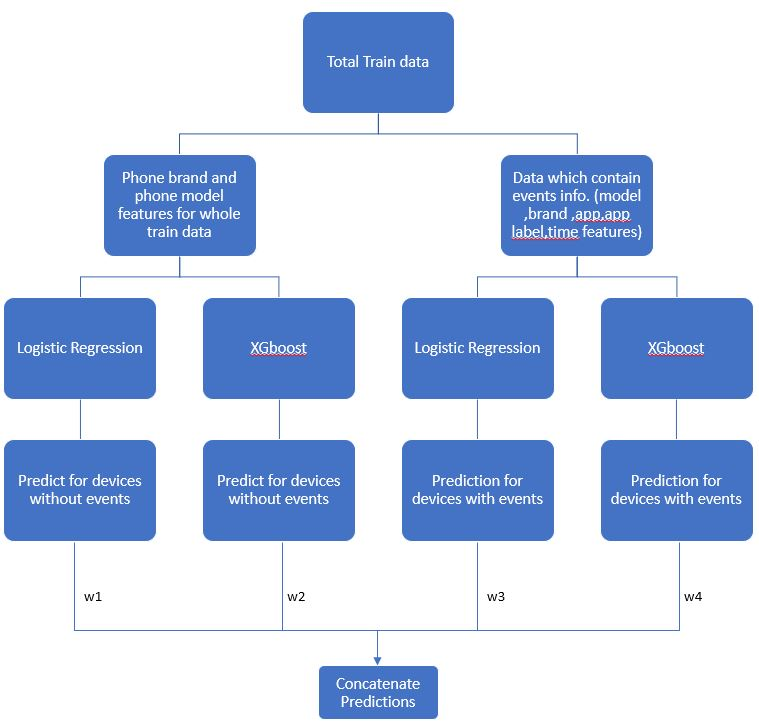

In [95]:
Image('diag2.jpg')

In [97]:
lr1=np.load("results/lr_noevents.npy")
lr2=np.load("results/lr_events.npy")

xgb1=np.load("results/xgb_noevents.npy")
xgb2=np.load("results/xgb_events.npy")

In [98]:
w1=0.5
w2=0.5
w3=0.3
w4=0.5

test1=(w1*lr1)+(w2*xgb1)

test2=(w3*lr2)+(w4*xgb2)

In [99]:
gatrain=pd.read_csv('data/gender_age_train.csv',index_col = 'device_id')
targetencoder = LabelEncoder().fit(gatrain.group)
y = targetencoder.transform(gatrain.group)
nclasses = len(targetencoder.classes_)

In [100]:
pred_1 = pd.DataFrame(test1, index = gatest_noevents.index, columns=targetencoder.classes_)
pred_2 = pd.DataFrame(test2, index = gatest_events.index, columns=targetencoder.classes_)
final_pred=pd.concat([pred_1,pred_2], axis=0)
final_pred.shape

(112071, 12)

In [101]:
final_pred.to_csv('final1.csv',index=True)

### 7.3.2 Approach 1: Ensembeling Neural Networks

1. for predicting test data with no events information we use nerual network from section 7.1.3 to get probabilities

2. For predicting test data which contains events information, we use a neural networks, we use neural networks from sections 7.2.1 and 7.2.2 and average the predictions

3. Finally we concatenate the predictions

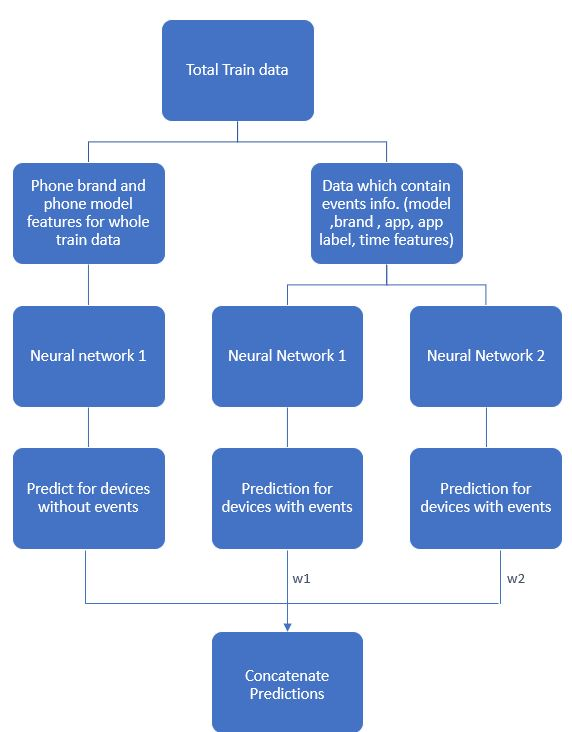

In [150]:
Image('diag.jpg')

In [73]:
lr=np.load("results/lr_noevents.npy")
noevents_nn1=np.load("results/nn1_noevents.npy")
noevents_nn2=np.load("results/nn2_noevents.npy")

events_nn1=np.load("results/newnn1_events.npy")
events_nn2=np.load("results/newnn2_events.npy")

In [74]:
w1=0.5
w2=0.5

test1=(1*noevents_nn1)

test2=(0.5*events_nn1)+(0.5*events_nn2)

In [75]:
gatrain=pd.read_csv('data/gender_age_train.csv',index_col = 'device_id')

In [76]:
targetencoder = LabelEncoder().fit(gatrain.group)
y = targetencoder.transform(gatrain.group)
nclasses = len(targetencoder.classes_)

In [153]:
pred_1 = pd.DataFrame(test1, index = gatest_noevents.index, columns=targetencoder.classes_)
pred_2 = pd.DataFrame(test2, index = gatest_events.index, columns=targetencoder.classes_)
final_pred=pd.concat([pred_1,pred_2], axis=0)
final_pred.shape

(112071, 12)

In [154]:
final_pred.to_csv('final1.csv',index=True)

# Section 8: Results:

### 8.1: Machine Learning model Ensemble 

**Private Score:**2.278

**Public Score:**2.275

Machine learning Ensemble seems to perform okay, but not enough to get in Top 10% of leaderboard

### 8.2: Neural Network Ensemble 

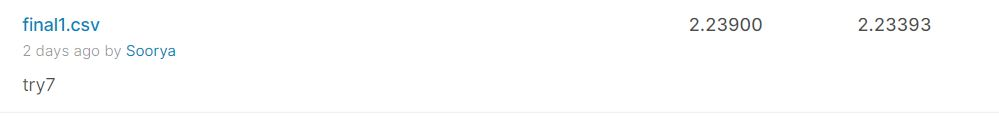

In [155]:
Image('score.jpg')

**Private Score:**2.23900

**Public Score:**2.23393

#### Both these  come under the Top 10% of leaderboard scores

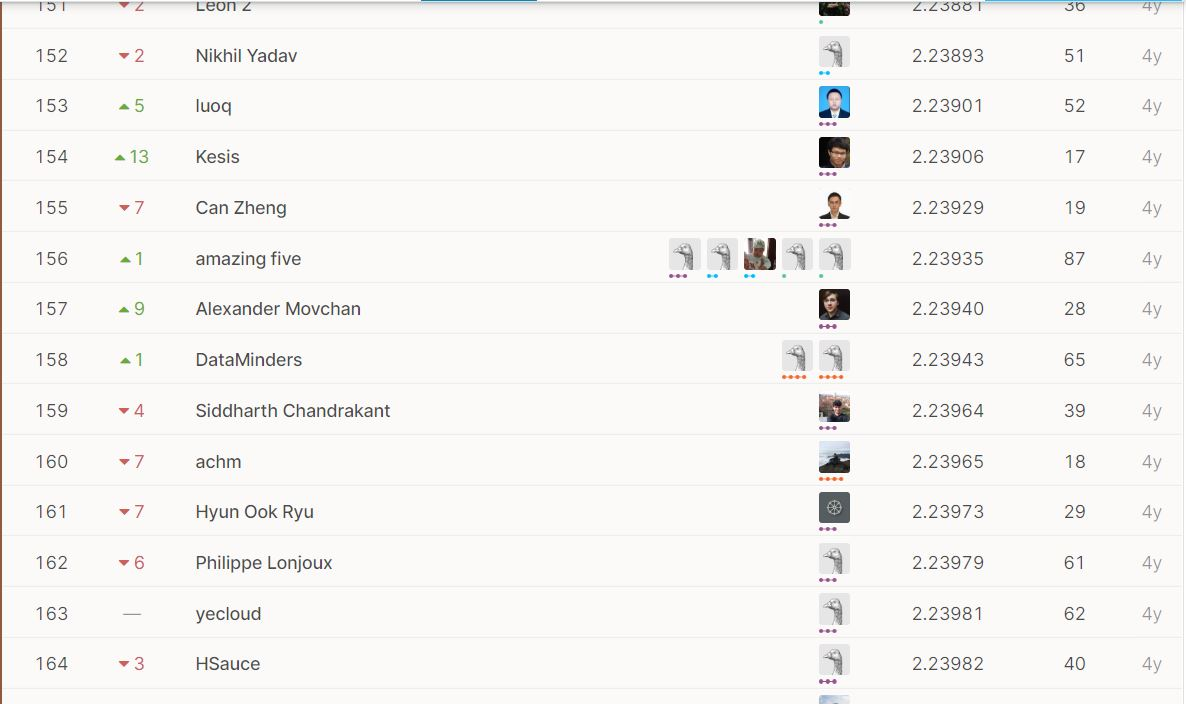

In [156]:
Image('Private-leaderboard.jpg')

**152nd out 1638 rank in private leaderboard**

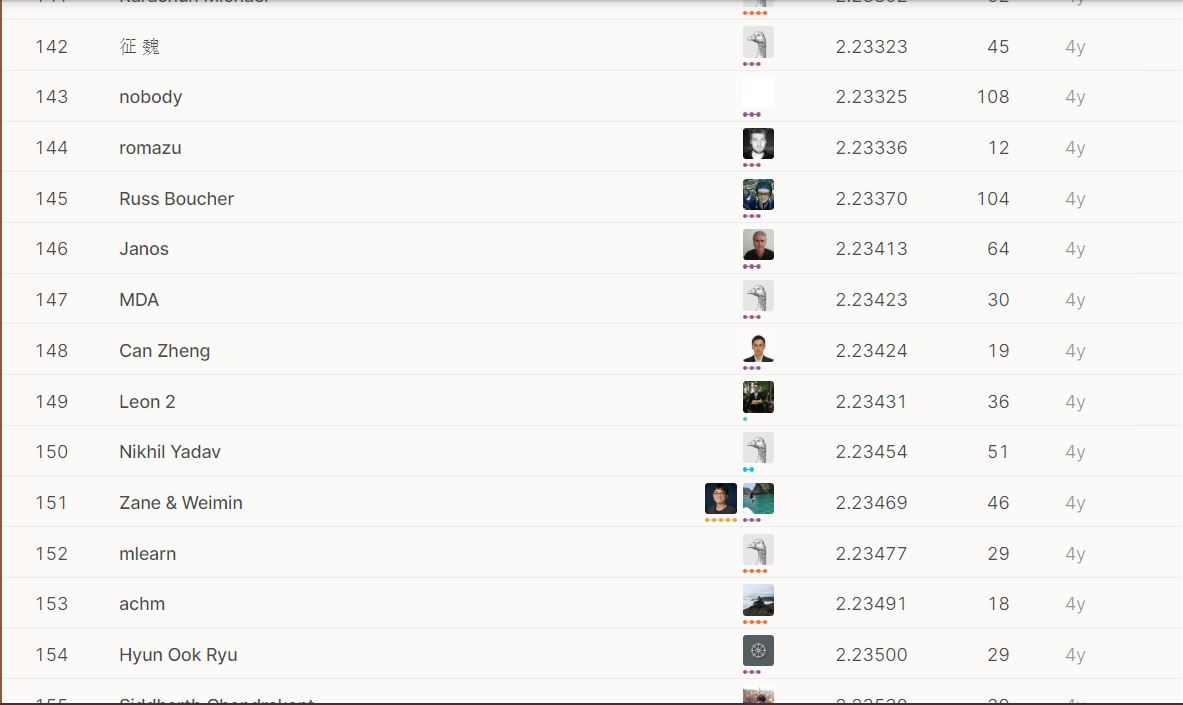

In [157]:
Image('Public-leaderboard.jpg')

**146th out 1638 in Public Leaderboard**

## Summary of models
#### Approach 1:

In [161]:
from prettytable import PrettyTable

pt = PrettyTable()
pt.field_names = ["Model", "Data", " CV Log-loss"]
pt.add_row(["Logistic Regression", "Whole data",  2.3379])
pt.add_row(["Neural Network", "Whole data",  2.3969])

print(pt)            

+---------------------+------------+--------------+
|        Model        |    Data    |  CV Log-loss |
+---------------------+------------+--------------+
| Logistic Regression | Whole data |    2.3379    |
|    Neural Network   | Whole data |    2.3969    |
+---------------------+------------+--------------+


#### Approach 2:

In [103]:
from prettytable import PrettyTable

pt = PrettyTable()
pt.field_names = ["Model", "Data", " Validation Log-loss"]
pt.add_row(["Logistic Regression", "without events",  2.3891])
pt.add_row(["XGboost", "without events",  2.3929])
pt.add_row(["Avg Neural Network1", "without events",  2.3518])
pt.add_row(["Avg Neural Network2", "without events",  2.3792])

pt.add_row(["Logistic Regression", "events",  2.01601])
pt.add_row(["XGboost", "events",  2.06007])
pt.add_row(["Avg Neural Network1", "events",  1.9166])
pt.add_row(["Avg Neural Network2", "events",  1.9078])

print(pt)            

+---------------------+----------------+----------------------+
|        Model        |      Data      |  Validation Log-loss |
+---------------------+----------------+----------------------+
| Logistic Regression | without events |        2.3891        |
|       XGboost       | without events |        2.3929        |
| Avg Neural Network1 | without events |        2.3518        |
| Avg Neural Network2 | without events |        2.3792        |
| Logistic Regression |     events     |       2.01601        |
|       XGboost       |     events     |       2.06007        |
| Avg Neural Network1 |     events     |        1.9166        |
| Avg Neural Network2 |     events     |        1.9078        |
+---------------------+----------------+----------------------+


## Overall Conclusions and Thoughts:

1. The data has a lot a missing values, about 70% of the data does not contain events information
2. The hardest part of this problem was creating features, as the data was distributed thorughtout various tables each having its own primary key
4. The data was split into 2 grps, devices which conatins events files and not contain events files, modelling was done seperately and its predictions were concatenated. This gave best results
5. Nerual Network ensembles were used, to achieve better log-loss
6. The best score on private leaderboard was 2.2390 and public leaderboard was 2.23391